### RESOURCE DESCRIPTION FRAMEWORK TO TEXT

## Importing required libraries

In [2]:
import pandas as pd
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
warnings.filterwarnings('ignore')

## Loading the processed data 

## Please look at the code [here](https://gist.github.com/MathewAlexander/d4853c2268a2293e479b773f0c317030) to preprocess the data

In [11]:
train_df=pd.read_csv('/Users/dalex/nlp/T5_nlg/webNLG2020_train.csv', index_col=[0])

In [12]:
train_df=train_df.iloc[ :500,:]

In [13]:
train_df=train_df.sample(frac = 1)

In [14]:
batch_size=8
num_of_batches=len(train_df)/batch_size
num_of_epochs=4

In [15]:
num_of_batches=int(num_of_batches)

Checking for the GPU availability

In [17]:
print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.0.1
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


## Loading the pretrained model and tokenizer

In [18]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
#moving the model to device(GPU/CPU)
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

## Initializing the Adafactor optimizer with parameter values suggested for t5

In [9]:

optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)


In [10]:

from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

In [11]:
num_of_epochs=1

## Training the model

In [12]:
#Sets the module in training mode
model.train()

loss_per_10_steps=[]
for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  
  running_loss=0

  out = display(progress(1, num_of_batches+1), display_id=True)
  for i in range(num_of_batches):
    inputbatch=[]
    labelbatch=[]
    new_df=train_df[i*batch_size:i*batch_size+batch_size]
    for indx,row in new_df.iterrows():
      input = 'WebNLG: '+row['input_text']+'</s>' 
      labels = row['target_text']+'</s>'   
      inputbatch.append(input)
      labelbatch.append(labels)
    inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=400,return_tensors='pt')["input_ids"]#when we do tokenisation we get tokens and their id
    labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=400,return_tensors="pt") ["input_ids"]
    inputbatch=inputbatch.to(device)
    labelbatch=labelbatch.to(device)

    # clear out the gradients of all Variables 
    optimizer.zero_grad()

    # Forward propogation
    outputs = model(input_ids=inputbatch, labels=labelbatch)
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num
    if i%10 ==0:      
      loss_per_10_steps.append(loss_num)
    out.update(progress(loss_num,i, num_of_batches+1))

    # calculating the gradients
    loss.backward()

    #updating the params
    optimizer.step()
    
  running_loss=running_loss/int(num_of_batches)
  print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
  

Running epoch: 1


Epoch: 1 , Running loss: 0.7921875998858483


## Plotting the loss over time

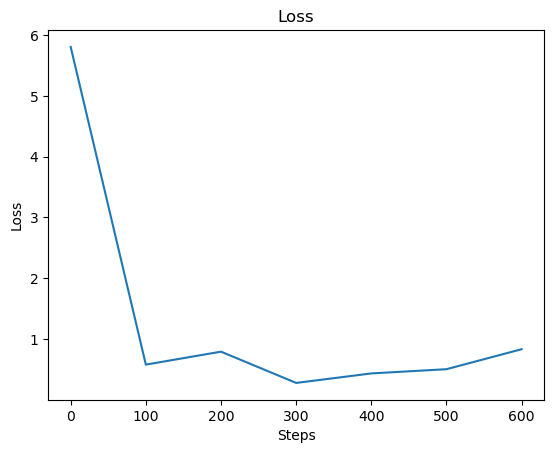

In [13]:
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

## Testing the model

In [14]:
model.eval()
input_ids = tokenizer.encode("WebNLG: sidharth | hometown | Delhi && sidharth | play |  football </s>", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(device)
outputs = model.generate(input_ids)
tokenizer.decode(outputs[0])

'<pad> Sidharth is a city of Delhi.</s>'

Before testing the model further, lets learn how to serialize it and load from the path

## Serializing the trained model

In [15]:
torch.save(model.state_dict(),'/Users/dalex/nlp/T5_nlg/pytoch_model_1ep.bin')


## Downloading the config file

In [18]:
os.chdir(os.getcwd())
!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json

--2023-09-14 10:05:10--  https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.224.128, 54.231.224.88, 54.231.199.96, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.224.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1199 (1.2K) [application/json]
Saving to: ‘t5-base-config.json’

t5-base-config.json 100%[===================>]   1.17K  --.-KB/s    in 0s      

2023-09-14 10:05:12 (22.0 MB/s) - ‘t5-base-config.json’ saved [1199/1199]



## Loading the trained model from the path

In [19]:
from transformers import T5ForConditionalGeneration, T5Config

model_path = '/Users/dalex/nlp/T5_nlg/pytoch_model_1ep.bin'
config_path = '/Users/dalex/nlp/T5_nlg/t5-base-config.json'  # Replace with the actual path to your T5 configuration file

config = T5Config.from_pretrained(config_path)
model = T5ForConditionalGeneration.from_pretrained(model_path, config=config)


## The Inference function

In [20]:
def generate(text):
  model.eval()
  input_ids = tokenizer.encode("WebNLG:{} </s>".format(text), return_tensors="pt")  # Batch size 1
  # input_ids.to(dev)
  s = time.time()
  outputs = model.generate(input_ids)
  gen_text=tokenizer.decode(outputs[0]).replace('<pad>','').replace('</s>','')
  elapsed = time.time() - s
  print('Generated in {} seconds'.format(str(elapsed)[:4]))

  
  return gen_text

# Now, Lets test it out !

In [21]:
generate(' Russia | leader | Putin')

Generated in 0.33 seconds


' Putin is the leader of Russia.'

In [22]:
generate('Sidhath | profession | Doctor  && Sidharth | home_town |  Bombay')

Generated in 0.53 seconds


' Sidharth is the home town of the Doctor & Sidharth.'

In [23]:
generate('Nie_Haisheng | birthDate | 1964-10-13  && Nie_Haisheng | occupation | Fighter_pilot ')

Generated in 0.45 seconds


' The Nie Haisheng was born on the day of the birth.'

In [ ]:
generate('Bananaman | creator | Steve_Bright &&  Bananaman | broadcastedBy | BBC')

Generated in 1.14 seconds


' Bananaman was created by Steve Bright and broadcasted by the BBC.'

In [25]:
generate('Bananaman | lastAired | "1986-04-15" && Bananaman | creator | Steve_Bright')

Generated in 0.46 seconds


' The Bananaman was last Aired on 1986-04-15.'

In [26]:
generate('Alan_B._Miller_Hall | currentTenants | Mason_School_of_Business && Alan_B._Miller_Hall | location | Williamsburg,_Virginia')

Generated in 0.40 seconds


' Alan B Miller Hall is located in Williamsburg, Virginia.'

## Results after quantization

In [29]:
import torch.quantization
import torch.nn as nn
torch.backends.quantized.engine = 'qnnpack'
quantized_model = torch.quantization.quantize_dynamic(
    model, {nn.Linear,nn.Dropout,nn.LayerNorm}, dtype=torch.qint8
)


Lets check the difference in size of the model

In [30]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print_size_of_model(model)
print_size_of_model(quantized_model)

Size (MB): 891.712182
Size (MB): 322.977442


In [31]:
def quant_generate(text):
  quantized_model.eval()
  input_ids = tokenizer.encode("WebNLG:{} </s>".format(text), return_tensors="pt")  # Batch size 1
  # input_ids.to(dev)
  s = time.time()
  outputs = quantized_model.generate(input_ids)
  gen_text=tokenizer.decode(outputs[0]).replace('<pad>','').replace('</s>','')
  elapsed = time.time() - s
  print('Generated in {} seconds'.format(str(elapsed)[:4]))

  
  return gen_text

Now lets check the difference in inference time

In [33]:
quant_generate('Facebook | CEO | Mark  && Facebook | number Of Employees | 52000 ')

Generated in 0.34 seconds


' The CEO of Facebook is the number of employees.'

In [34]:
generate('Facebook | CEO | Mark  && Facebook | number Of Employees | 52000 ')

Generated in 0.62 seconds


' Facebook is the number of employees of Mark && Facebook.'